In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
import LTransform as LT
from get_utils import get_hidden, get_force
from pathlib import Path
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import seaborn as sb
import scipy.stats as stats
from plot import *
from copy import deepcopy
#%matplotlib widget
#%matplotlib qt
%matplotlib inline

In [35]:
from tdr import gsog

folder_name = 'Sim_all' 
#folder_name = 'Sim_all'

ff_coef = [0,8,0,8]
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
labels = ['NF1','FF1','NF2','FF2']

T = pd.DataFrame()

N_idx = 15 # index of hidden activity 
F_idx = 24 # index of force

rdms = []
for mn in range(0,20):
    model_name = "model{:02d}".format(mn)
    
    data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)
    force = get_force(folder_name,model_name,phase,ff_coef)

    for i in range(len(data)):
        data[i] = data[i][:,N_idx,:]
        force[i] = force[i][:,F_idx,:]

    # remove overall mean
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    data_wm = deepcopy(data)

    for i in range(len(data)):
        data[i] = data[i]-mean_N

    # use NF1 to project onto TDR axes
    X = force[0] # NF1 force 
    N = data[0] # NF1 hidden activity

    X = np.hstack((X,np.ones((X.shape[0],1))))
    beta_b2n = np.linalg.pinv(X) @ N

    # Compute the TDR axes.
    beta_n2b = np.linalg.pinv(beta_b2n)
    beta_n2b = beta_n2b[:,:2]

    # Orthogonalize the TDR axes before projection.
    beta_n2b_orth = gsog(beta_n2b)[0]

    # Project before-learning and after-learning neural activity onto the TDR axes
    data_p = deepcopy(data)
    for i in range(len(data)):
        data_p[i] = data_p[i] @ beta_n2b_orth
    
    # RDM
    D = np.stack(data_p)
    dims = D.shape
    D = D.reshape(dims[0],-1)
    rdms.append(pdist(D))


    # uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0)
    us = us.reshape(-1,1)
    us_orth = us - np.dot(beta_n2b_orth[:,0],us)/np.linalg.norm(beta_n2b_orth[:,0])**2 * beta_n2b_orth[:,0][:,None]
    us_orth = us_orth - np.dot(beta_n2b_orth[:,1],us_orth)/np.linalg.norm(beta_n2b_orth[:,1])**2 * beta_n2b_orth[:,1][:,None]

    # np.dot(beta_n2b_orth[:,1],us_orth) # sanity check
    us_orth_norm = us_orth/np.linalg.norm(us_orth)
    
    for i,l in enumerate(labels):
        u = data_wm[i]@us_orth_norm
        u = np.mean(u)

        d = {'mn':[mn],'phase':[l],'us':[u]}
        T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)

# Project on the Force space

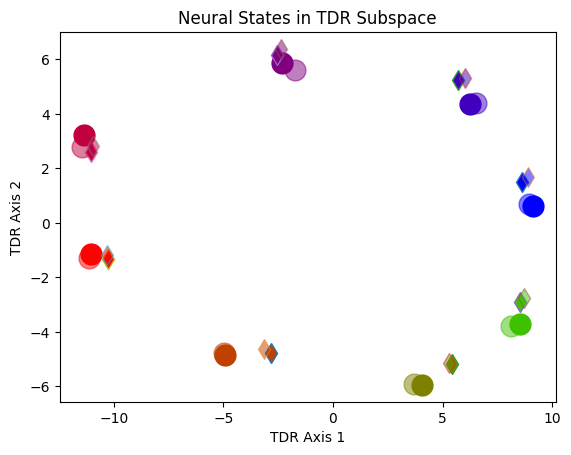

In [36]:
angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
#angle_set = np.deg2rad(np.array([0,45,60,75,90,105,120,135,180,225,315]))
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]
n_cond = len(angle_set)

# Create a scatter plot
plt.figure()
for i in range(n_cond):
    plt.plot(data_p[0][i,0], data_p[0][i,1],'.', markersize=30, color=color_list[i])
    plt.plot(data_p[1][i,0], data_p[1][i,1],'d', markersize=10, markerfacecolor=color_list[i])
    plt.plot(data_p[2][i,0], data_p[2][i,1],'.', markersize=30, color=color_list[i],alpha=0.5)
    plt.plot(data_p[3][i,0], data_p[3][i,1],'d', markersize=10, markerfacecolor=color_list[i],alpha=0.5)
    #plt.plot(data_p[4][i,0], data_p[4][i,1],'>', markersize=10, markerfacecolor=color_list[i],alpha=0.5)

plt.xlabel('TDR Axis 1')
plt.ylabel('TDR Axis 2')
plt.title('Neural States in TDR Subspace')

plt.show()

# Better visualization

In [37]:
label = []

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        pair = f'({labels[i]},{labels[j]})'
        label.append(pair)

T-statistic: 1.752356584090349
P-value: 0.0958357942654506


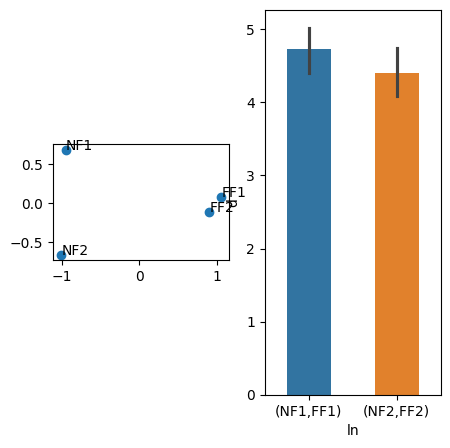

In [38]:
import PcmPy as pcm
labels = ['NF1','FF1','NF2','FF2']

rdm_avg = np.mean(np.stack(rdms,axis=0),axis=0)
rdm_m = squareform(rdm_avg)

n_cond = rdm_m.shape[0]

H = np.eye(n_cond) - np.ones((n_cond,n_cond))/n_cond
G = -0.5*H@rdm_m@H

# np.sum(pcm.G_to_dist(G)-rdm_m) # sanity check
W,Glam = pcm.classical_mds(G)

fig,ax = plt.subplots(1,2,figsize=(5,5))


ax[0].scatter(W[:,0],W[:,1])
ax[0].set_aspect('equal')

for i, label in enumerate(labels):
    ax[0].annotate(label, (W[i,0],W[i,1]))


# bar plot
select = [0,5]
#select = [0,7,8]


label = []

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        pair = f'({labels[i]},{labels[j]})'
        label.append(pair)

L = pd.DataFrame()

for i in range(len(rdms)):
    for j in select:
        d = {'m':[i],'ln':[label[j]],'d':[rdms[i][j]]}
        L = pd.concat([L,pd.DataFrame(d)],ignore_index=True)

ax[1] = sb.barplot(x='ln',y='d',data=L,hue='ln',width=0.5)

sample1 = L.d[L.ln == '(NF1,FF1)'].to_numpy()
sample2 = L.d[L.ln == '(NF2,FF2)'].to_numpy()
sample3 = L.d[L.ln == '(NF2,FF2-)'].to_numpy()

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample1, sample2)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

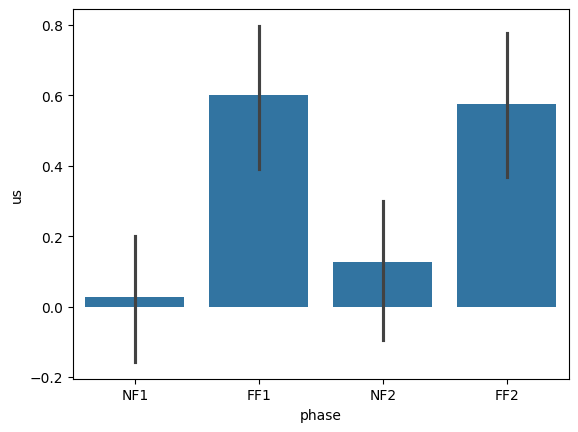

In [39]:
# Assuming T is your DataFrame
sb.barplot(x='phase', y='us', data=T)
plt.show()

In [40]:
sample1 = T.us[T.phase == 'NF1'].to_numpy()
sample2 = T.us[T.phase == 'FF1'].to_numpy()
sample3 = T.us[T.phase == 'NF2'].to_numpy()
sample4 = T.us[T.phase == 'FF2'].to_numpy()
sample5 = T.us[T.phase == 'FF2-'].to_numpy()


# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample1, sample3)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -6.967434560640973
P-value: 1.224083226688924e-06


In [41]:
# relate behavior to neural activity

# the amount of saving to the difference between sample3 and sample1
sample2


array([ 0.30305412,  0.29571665,  0.39034965,  1.46873602, -0.7315987 ,
        0.06330657,  0.55520128,  0.73919866,  1.32510371,  0.73609763,
        0.31224118,  0.27230628,  1.12663448,  0.79027185,  0.59299407,
        1.0304632 ,  0.74285438,  0.35273244,  1.1610937 ,  0.48895055])

In [42]:
saving_neural = sample3-sample1

In [43]:
from scipy.optimize import minimize
import numpy as np


class Exp_c():
    def __init__(self):
        #self.n_param = 5
        pass
    def predict(self,theta=None):
        if theta is None:
            theta = self.theta
        #pred = theta[0]*np.exp(-theta[1]*self.x**2)+ theta[2]

        # pred = np.exp(theta[0])*np.exp(-np.exp(theta[1])*self.x**3) +\
        #       np.exp(theta[2])*np.exp(-np.exp(theta[3])*self.x**2) +\
        #         np.exp(theta[4])*np.exp(-np.exp(theta[5])*self.x**1) + theta[6] 
        
        pred = np.exp(theta[0])*np.exp(-np.exp(theta[1])*self.x**3) +\
                np.exp(theta[2])*np.exp(-np.exp(theta[3])*self.x**1) + theta[4] 

        return pred
    def fro(self,theta,loss,lam=None):
        pred = self.predict(theta)
        return np.linalg.norm(loss-pred)+lam*np.sum(np.abs(theta))
    def fit(self,loss,lam=None):
        if lam is None:
            lam = 0
        self.x = np.arange(len(loss))
        theta0 = [-1,-1,-1,-1,20]
        theta = minimize(self.fro,theta0,args=(loss,lam),method='Nelder-Mead',options={'maxiter':10000,'disp':False})
        self.theta = theta.x
        self.success = theta.success
    def find_x(self,loss_thresh):
        pred = self.predict()
        idx = np.where(pred<=loss_thresh)[0]
        return idx[0]

phases = {'FF1':[8],'FF2':[8]}
num_model = 20
loss_type = 'position'
w = 1

all_phase = list(phases.keys())

# load behavior and start fitting
loss = {phase: [] for phase in phases.keys()}
for i,phase in enumerate(phases.keys()):
    for m in range(num_model):
        model_name = "model{:02d}".format(m)
        _,_,log=get_dir(folder_name, model_name, phase, phases[phase][0])
        log = json.load(open(log,'r'))
        loss[phase].append(log[loss_type])

    # Calculate window averages for all models
    loss[phase] = [window_average(np.array(l), w) for l in loss[phase]]


In [44]:
saving_behav = np.array(loss['FF1'])[:,0] - np.array(loss['FF2'])[:,0]

In [45]:
saving_behav

array([1.06700897, 0.88932419, 0.53317261, 1.11777878, 1.39472961,
       0.82559967, 0.61324692, 0.86649704, 1.40869904, 0.98851776,
       1.66813278, 1.47305679, 0.47382736, 1.36358643, 0.66932678,
       1.84035492, 1.72473145, 1.86413574, 0.94750977, 2.21630096])

In [46]:
stats.ttest_1samp(saving_behav,0)

TtestResult(statistic=10.83512820573988, pvalue=1.4241517849347618e-09, df=19)

In [50]:
idx = {'FF1':[],'FF2':[]}
for m in range(num_model):
    for i,phase in enumerate(phases.keys()):
        l = loss[phase][m]
        T = Exp_c()
        T.fit(l,lam=0.0)
        if phase=='FF1':
            pred = T.predict()
            loss_thresh = np.mean(pred[-100:])*1.15
            
            #loss_thresh = T.theta[-1]*1.05
        idx[phase].append(T.find_x(loss_thresh))


# fig,ax = plt.subplots(1,1,figsize=(6,5))
# ax.plot(loss['FF2'][13],linestyle='-',color='b',label='data')

# T = Exp_c()
# T.fit(loss['FF2'][13],lam=0.0)

# ax.plot(T.predict(),linestyle='--',color='r',label='pred')

# #loss_thresh = T.theta[-1]*1.05
# idx = T.find_x(loss_thresh)
# ax.axvline(idx,linestyle='--',color='k')
# ax.legend()
saving_behav = np.array(idx['FF1'])-np.array(idx['FF2'])

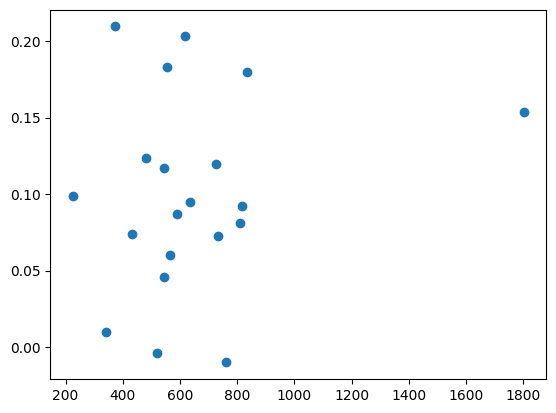

In [51]:
plt.scatter(saving_behav,saving_neural)

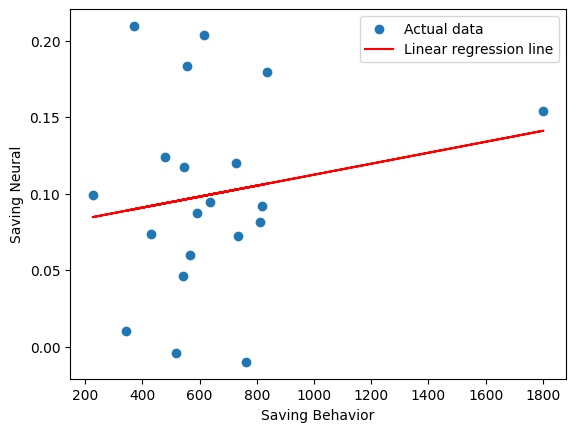

In [52]:
from sklearn.linear_model import LinearRegression

# Reshape the data if needed
saving_behav = saving_behav.reshape(-1, 1)
saving_neural = saving_neural.reshape(-1, 1)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(saving_behav, saving_neural)

# Make predictions
predictions = model.predict(saving_behav)

# Plot the data and the regression line
plt.scatter(saving_behav, saving_neural, label='Actual data')
plt.plot(saving_behav, predictions, color='red', label='Linear regression line')
plt.xlabel('Saving Behavior')
plt.ylabel('Saving Neural')
plt.legend()
plt.show()

In [53]:
import statsmodels.api as sm

saving_behav = saving_behav.reshape(-1, 1)

# Add a constant term to the input for the intercept
X = sm.add_constant(saving_behav)

# Fit the model to the data using statsmodels
model = sm.OLS(saving_neural, X).fit()

# Get the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.5933
Date:                Fri, 02 Feb 2024   Prob (F-statistic):              0.451
Time:                        12:39:33   Log-Likelihood:                 27.448
No. Observations:                  20   AIC:                            -50.90
Df Residuals:                      18   BIC:                            -48.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0765      0.033      2.295      0.0